In [1]:
# change working directory to the project root
import os
os.chdir('../../')

import sys
sys.path.append('models/utils')
sys.path.append('models/brian2')
sys.path.append('models/aln')

In [6]:
import os
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import scipy.signal

import fitparams as fp
import functions as func
import runModels as rm
import paths

import loadparams as lp

In [27]:
from brian2 import *
import time
import network_sim as net # AdEx network simulation

In [3]:
# sett dpi for notebooks on server
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['image.cmap'] = 'plasma'

In [28]:
def runAdEx(params):
    '''
    Runs an AdEx network simulation
    '''

    stimulus = params['ext_exc_current']
    if not hasattr(stimulus, "__len__"): # in case stimulus is only a number
        stimulus = [stimulus] # convert it to a list (the way that set_network_params expects it)

    net_params, ext_input = lp.set_network_params(params, stimulus)

    # prepare brian2 simulation 
    set_device('cpp_standalone', build_on_run=False)
    device.insert_code(
        'main', 'srand(' + str(int(time.time()) + os.getpid()) + ');')
    results = lp.init_resultsdict()

    # destination for build files of brian2 cpp standalone mode
    try:
        compile_dir = paths.BRIAN2_COMPILE_DIR
    except:
        compile_dir = "models/brian2/brian2_compile/"
    if not os.path.isdir(compile_dir): os.makedirs(compile_dir)

    # run
    results['model_results']['net'] = net.network_sim(
        ext_input, net_params, rec=True, standalone_dir = compile_dir)
    
    rates_exc_net = results['model_results']['net']['r_e']
    rates_inh_net = results['model_results']['net']['r_i'][0]

    t_net = results['model_results']['net']['t']
    
    device.reinit()
    device.activate()    

    return t_net, rates_exc_net, rates_inh_net, stimulus, results['model_results']['net']

In [223]:
simulations = {}

In [224]:
states = ['A2', 'A3', 'B3']
for s in states:
    print("Simulating point {}".format(s))
    params = []
    params = fp.loadpoint(params, s)
    params = fp.loadpoint_network(params, s)

    params['dt'] = 0.2
    params['duration'] = 2000.0
    params['sigma_ou'] = 0.0
    params['model'] = 'brian'
    N_neurons = 5000
    params['N'] = N_neurons
    
    t_net, rates_exc_net, rates_inh_net, stimulus, results = runAdEx(params)
    
    simulations[s] = {}
    simulations[s]['t'] = t_net
    simulations[s]['rates_exc'] = rates_exc_net
    simulations[s]['spikes'] = results['net_spikes']

Simulating point A1
Simulating 5000 excitatory and 5000 inhibitory neurons (total 10000) ...
E spikes: 100 I spikes: 251
runtime: 64.1
Simulating point A2
Simulating 5000 excitatory and 5000 inhibitory neurons (total 10000) ...
E spikes: 6178 I spikes: 1969
runtime: 108.9
Simulating point A3
Simulating 5000 excitatory and 5000 inhibitory neurons (total 10000) ...
E spikes: 3719 I spikes: 4648
runtime: 110.3
Simulating point B3
Simulating 5000 excitatory and 5000 inhibitory neurons (total 10000) ...
E spikes: 2076 I spikes: 2504
runtime: 79.4


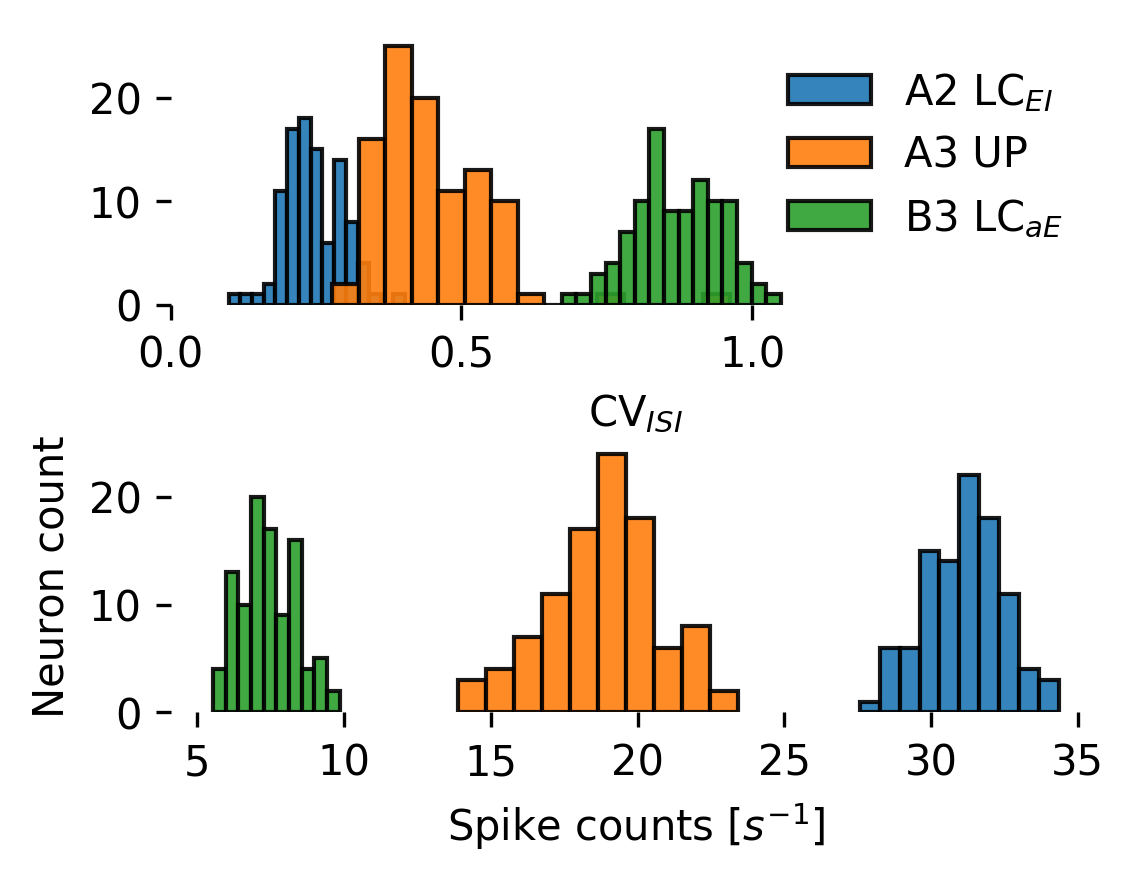

In [317]:
fig, axs = plt.subplots(2, 1, figsize=(4, 3))
for si, s in enumerate(['A2', 'A3', 'B3']):
    spikes = simulations[s]['spikes']
    sp = spikes[0]
    times = spikes[1]
    nNeurons = max(sp) + 1
    nSpikes = len(sp)

    spiketimes = {}
    for n in range(nNeurons):
        ts = list(times[(np.where(sp == n))])
        ts = [t for t in ts if t > 500 * ms]
        spiketimes[n] = ts
    isi_stds = []
    isi_cvs = []
    for n in range(nNeurons):
        isi_std = np.std(np.diff(spiketimes[n]))
        isi_cv = np.std(np.diff(spiketimes[n])) / np.mean(np.diff(spiketimes[n]))
        #plt.scatter(n, np.std(np.diff(spiketimes[n])))
        isi_stds.append(isi_std)  
        isi_cvs.append(isi_cv)
        
    meanFiringRates = []
    for n in range(nNeurons):
        meanFiringRates.append(1 / np.mean(np.diff(spiketimes[n])))
        
    if s == 'A2':
        label = 'A2 LC$_{EI}$'
    elif s == 'A3':
        label = 'A3 UP'   
    elif s == 'B3':
        label = 'B3 LC$_{aE}$'         
    else:
        label = s
        
    colors = ['k', 'C3', 'C1']
    color = colors[si]

    axs[0].hist(isi_cvs, bins=15, label=label, alpha=0.9, edgecolor='black',);
    axs[1].hist(meanFiringRates, bins=10, label=label, alpha=0.9, edgecolor='black',);
    
    for k in range(1):
        leg = axs[k].legend(loc=1)
        leg.get_frame().set_facecolor('none')
        leg.get_frame().set_linewidth(0.0)
   
for k in range(2):
    axs[k].spines['right'].set_visible(False)
    axs[k].spines['top'].set_visible(False)
    axs[k].spines['bottom'].set_visible(False)
    axs[k].spines['left'].set_visible(False)
axs[0].set_xticks([0, 0.5, 1.0])
axs[0].set_yticks([0, 10, 20])

axs[0].set_xlim(0, 1.6)
axs[0].set_xlabel("CV$_{ISI}$")
axs[1].set_xlabel("Spike counts [$s^{-1}$]")

#axs[0].set_ylabel("Neuron count")
axs[1].set_ylabel("Neuron count")

plt.subplots_adjust(hspace=0.5)

In [227]:
def raster_plot(ax, times, sp):
    nNeurons = max(sp) + 1
    nSpikes = len(sp)
    spiketimes = {}
    for n in range(nNeurons):
        spiketimes[n] = list(times[np.where(sp == n)])
    for n in range(nNeurons):
        for spiketime in spiketimes[n]:
            ax.scatter(spiketime/ms, n, c='k', s=0.5)
            
#raster_plot(plt, t, i)

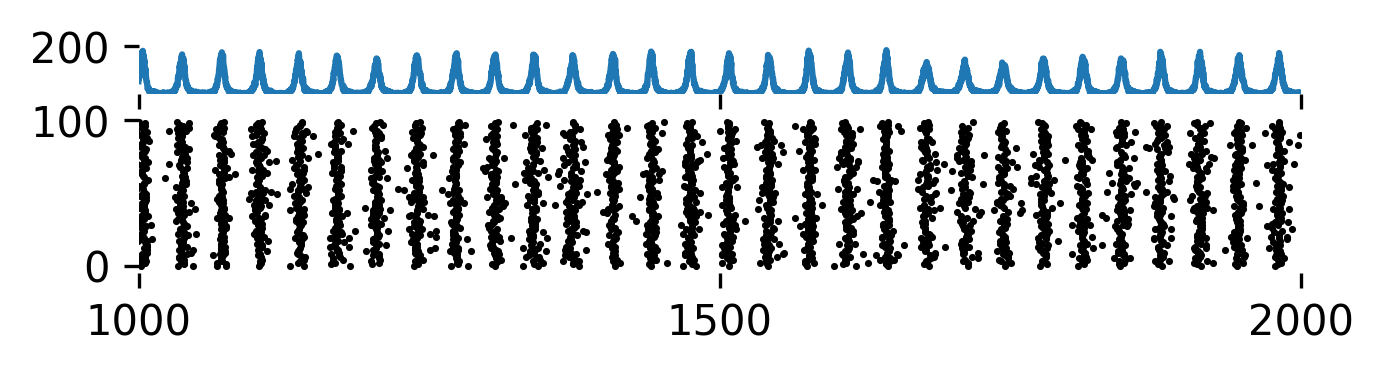

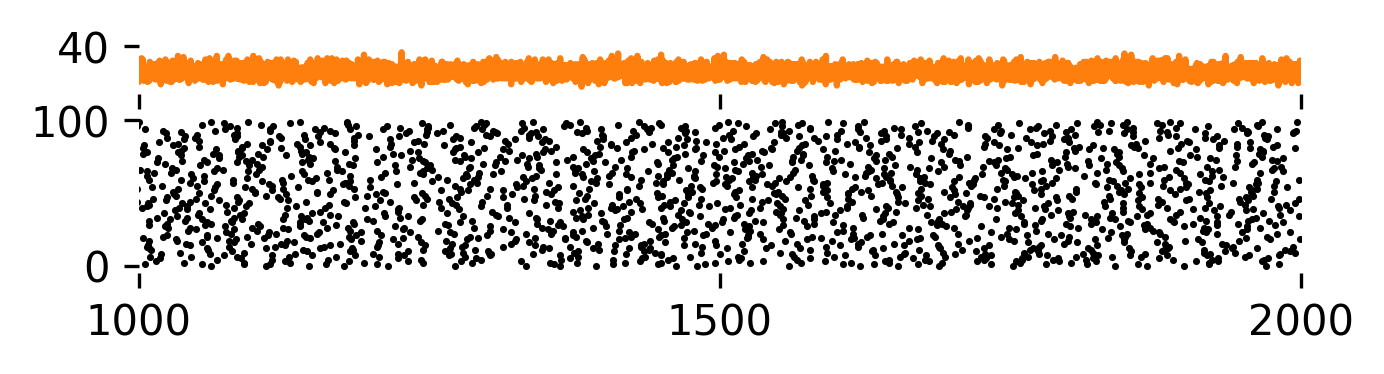

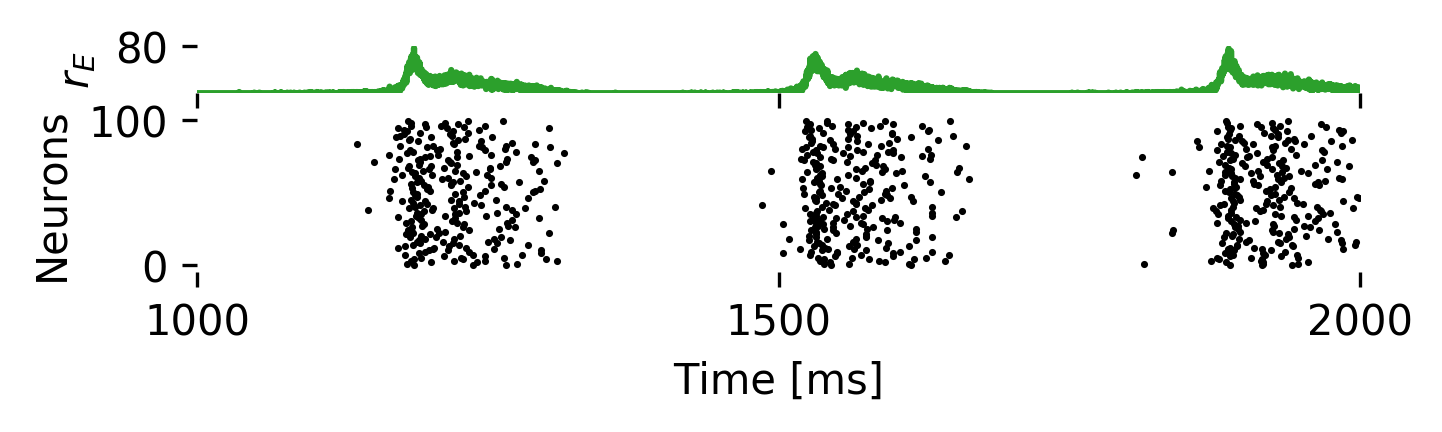

In [315]:
for si, s in enumerate(['A2', 'A3', 'B3']):
    spikes = simulations[s]['spikes']
    i = spikes[0]
    t = spikes[1]
    
    t_net = simulations[s]['t']
    rates_exc_net = simulations[s]['rates_exc']
    
    fig, axs = plt.subplots(2, 1, figsize=(5, 1), dpi=600, sharex = True, gridspec_kw={'height_ratios' : [1.5, 5]})
    
    colors = ['C0', 'C1', 'C2']
    color = colors[si]
    
    axs[0].plot(t_net, rates_exc_net, c=color)
    #axs[1].plot(t/ms, i, '.k',0.1, lw=0.1)
    raster_plot(axs[1], t, i)
    axs[0].set_ylim(0, np.round(max(10, np.max(rates_exc_net[t_net>500])),decimals = -1))
    if si == 2:
        axs[0].set_ylabel("$r_E$")
        axs[1].set_ylabel("Neurons")
    #axs[0].set_title("{}".format(s))
    axs[0].set_yticks([np.round(max(10, np.max(rates_exc_net[t_net>500])),decimals = -1)])
    
    for k in range(2):
        axs[k].spines['right'].set_visible(False)
        axs[k].spines['top'].set_visible(False)
        axs[k].spines['bottom'].set_visible(False)
        axs[k].spines['left'].set_visible(False)
    if si == 2:
        plt.xlabel("Time [ms]")
    
    plt.xticks([1000, 1500, 2000])
        
    plt.xlim(1000, 2000)
    plt.show()